## Лабораторна робота №1

**Тема**: Навчання з підкріпленням на основі середовища Frozen Lake бібліотеки Gymnasium.

Методи динамічного програмування та часової різниці (Temporal-Difference)

**Виконав:** студент групи КМ-12 Пономаренко Олександр

***Підгрупа №3***

#### 0. Встановити бібліотеку [Gymnasium](https://gymnasium.farama.org)

In [41]:
# !pip install gymnasium
# !pip install seaborn

#### 1. Ознайомитись з описом середовища [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

In [1]:
import gymnasium as gym

In [34]:
# Створюємо середовище Frozen Lake 4x4 з вимкненою сковзкістю
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False)

# Огляд початкової конфігурації середовища
state = env.reset()
print("Початковий стан:", state)
env.render()

Початковий стан: (0, {'prob': 1})


#### 2. Обчислити функцію ціни стану $v_{π_1}(s)$ для рівноймовірної (випадкової) стратегії $π_1$ при параметрі $𝛾$ = 0,75:
>   **a. за допомогою ітераційного алгоритму Оцінювання стратегії (Policy Evaluation).**

>   **b. за допомогою розв'язання системи рівнянь Белмана для функції ціни стану відносно невідомих значень $x_i = v_{π_1}(s_i)$**

#### Вивести отримані значення у вигляді матриці або теплової карти. 
#### Чи бачите Ви можливі шляхи до покращення рівноймовірної стратегії?

In [70]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import solve

In [71]:
# Ітераційний метод оцінювання стратегії
def policy_evaluation(env, policy, gamma=0.75, theta=1e-6):
    # Ініціалізуємо значення функції ціни стану нулями
    V = np.zeros(env.observation_space.n)
    
    # Отримуємо доступ до реального середовища
    env = env.unwrapped
    
    while True:
        delta = 0  # Відстежуємо зміни у значеннях V для зупинки
        for s in range(env.observation_space.n):
            v = 0
            # Проходимо всі можливі дії та стани
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, abs(v - V[s]))
            V[s] = v
        if delta < theta:  # Якщо зміни досить малі, виходимо з циклу
            break
    return V

# Створюємо середовище
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False)

# Рівноймовірна стратегія (кожна дія має однакову ймовірність)
policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n

# Обчислюємо функцію ціни стану для рівноймовірної стратегії
V = policy_evaluation(env, policy)

# Виводимо функцію ціни стану
print("Функція ціни стану для рівноймовірної стратегії:")
print(V.reshape((4, 4)))

Функція ціни стану для рівноймовірної стратегії:
[[0.00092935 0.00110441 0.00385693 0.00115701]
 [0.0019954  0.         0.0144523  0.        ]
 [0.00771773 0.03144824 0.073222   0.        ]
 [0.         0.08678424 0.34461682 0.        ]]


In [72]:
# Розв'язання системи рівнянь Белмана
def build_bellman_equations(env, gamma=0.75):
    n_states = env.observation_space.n
    A = np.eye(n_states)  # Стартова матриця A
    b = np.zeros(n_states)  # Вектор b

    # Отримуємо доступ до реального середовища
    env = env.unwrapped
    
    for s in range(n_states):
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[s][a]:
                A[s, next_state] -= gamma * prob / env.action_space.n  # Оновлюємо A
                b[s] += prob * reward / env.action_space.n  # Оновлюємо b
    return A, b

# Створюємо матриці для системи рівнянь Белмана
A, b = build_bellman_equations(env)

# Розв'язуємо систему рівнянь
V_bellman = solve(A, b)

# Виводимо функцію ціни стану, розв'язану через рівняння Белмана
print("Функція ціни стану (розв'язок через рівняння Белмана):")
print(V_bellman.reshape((4, 4)))

Функція ціни стану (розв'язок через рівняння Белмана):
[[0.00093013 0.00110475 0.00385713 0.00115714]
 [0.00199568 0.         0.01445234 0.        ]
 [0.00771784 0.03144827 0.07322202 0.        ]
 [0.         0.08678425 0.34461683 0.        ]]


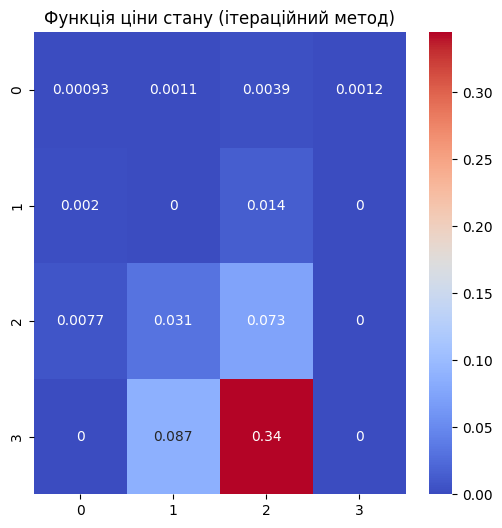

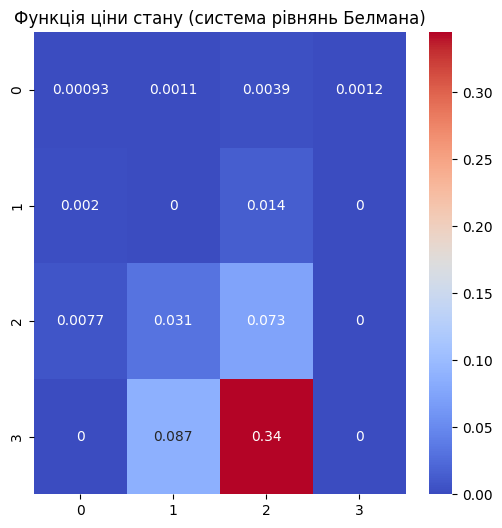

In [73]:
# Візуалізація функції ціни стану через теплову карту
def plot_value_function(V, title="Функція ціни стану"):
    plt.figure(figsize=(6,6))
    sns.heatmap(V.reshape((4,4)), annot=True, cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()

# Виводимо функцію ціни стану для обох методів
plot_value_function(V, "Функція ціни стану (ітераційний метод)")
plot_value_function(V_bellman, "Функція ціни стану (система рівнянь Белмана)")

#### 3. Використовуючи знайдені значення функції ціни стану $v_{π_1}(s)$ та рівняння Белмана для функції ціни дії-стану, оцінити функцію ціни дії-стану $q_{π_1}(s_j, a_j)$.

In [74]:
def compute_q_values(env, V, gamma=0.75):
    """
    Обчислення функції ціни дії-стану q(s, a) на основі функції ціни стану V(s).
    
    Параметри:
    - env: середовище Gymnasium (Frozen Lake).
    - V: значення функції ціни стану.
    - gamma: коефіцієнт дисконтування (γ).
    
    Повертає:
    - q_values: матриця розміром [кількість станів, кількість дій] для q(s, a).
    """
    
    # Отримуємо доступ до реального середовища
    env = env.unwrapped
    
    # Ініціалізуємо матрицю функції ціни дії-стану нулями
    q_values = np.zeros((env.observation_space.n, env.action_space.n))
    
    # Обчислюємо значення q(s, a) для кожної пари стану та дії
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            q_sa = 0  # Початкове значення для q(s, a)
            # Проходимо всі можливі наступні стани та ймовірності переходів
            for prob, next_state, reward, done in env.P[s][a]:
                # Обчислюємо значення q(s, a) через рівняння Белмана
                q_sa += prob * (reward + gamma * V[next_state])
            q_values[s, a] = q_sa
    
    return q_values

# Обчислюємо функцію ціни дії-стану на основі знайденої функції ціни стану V
q_values = compute_q_values(env, V)

# Виводимо функцію ціни дії-стану
print("Функція ціни дії-стану q(s, a) для рівноймовірної стратегії:")
print(q_values)

Функція ціни дії-стану q(s, a) для рівноймовірної стратегії:
[[6.97012896e-04 1.49654653e-03 8.28310221e-04 6.97012896e-04]
 [6.97012896e-04 0.00000000e+00 2.89269824e-03 8.28310221e-04]
 [8.28310221e-04 1.08392220e-02 8.67754265e-04 2.89269824e-03]
 [2.89269824e-03 0.00000000e+00 8.67754265e-04 8.67754265e-04]
 [1.49654653e-03 5.78829705e-03 0.00000000e+00 6.97012896e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.49165009e-02 0.00000000e+00 2.89269824e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.78829705e-03 0.00000000e+00 2.35861771e-02 1.49654653e-03]
 [5.78829705e-03 6.50881771e-02 5.49165009e-02 0.00000000e+00]
 [2.35861771e-02 2.58462616e-01 0.00000000e+00 1.08392220e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.50881771e-02 2.58462616e-01 2.35861771e-02]
 [6.50881771e-02 2.58462616e-01 1.00000000e+00 5.49165009

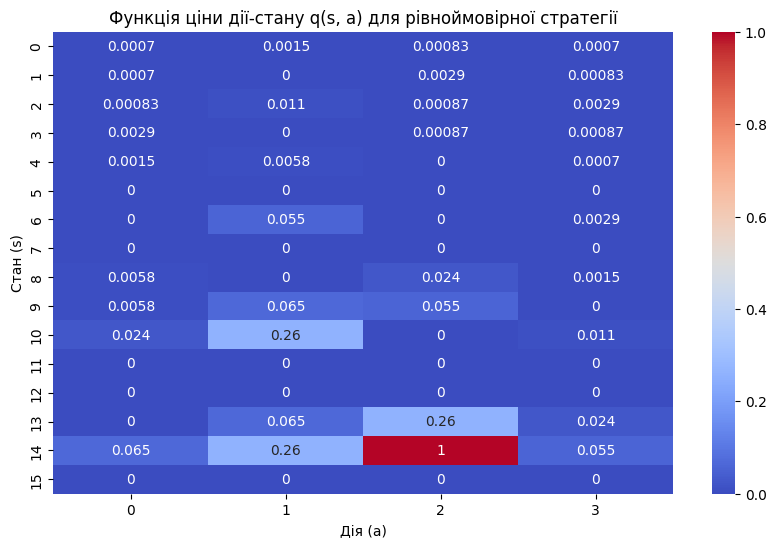

In [75]:
def plot_q_values(q_values, title="Функція ціни дії-стану q(s, a)"):
    """
    Візуалізація функції ціни дії-стану q(s, a).
    """
    plt.figure(figsize=(10,6))
    sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.xlabel("Дія (a)")
    plt.ylabel("Стан (s)")
    plt.show()

# Візуалізуємо функцію ціни дії-стану
plot_q_values(q_values, "Функція ціни дії-стану q(s, a) для рівноймовірної стратегії")

#### 4. Створити функцію $equiprobable$, результатом якої є номер дії. Дія обирається випадковим чином з множини допустимих дій.

In [76]:
def equiprobable(env):
    """
    Функція, яка обирає випадкову дію з множини допустимих дій у середовищі.
    
    Параметри:
    - env: середовище Gymnasium
    
    Повертає:
    - action: випадково вибрана дія
    """
    # Вибираємо випадкову дію з множини можливих дій
    action = np.random.choice(env.action_space.n)
    return action

In [77]:
# Викликаємо функцію equiprobable для випадкового вибору дії
random_action = equiprobable(env)
print("Випадково вибрана дія:", random_action)

Випадково вибрана дія: 1


#### 5. Створити функцію $get$_$episode$, яка приймає у якості аргументу екземпляр середовища, а результатом функції є епізод, тобто список кортежів, кожен з яких зберігає всі характеристики кожного кроку агента (тобто попередній стан, дію, винагороду, поточний стан, значення параметрів terminated та truncated). Вибір агентом дії у кожному стані на даному етапі реалізуйте на основі функції $equiprobable$, або, іншими словами, на основі рівноймовірної (випадкової) стратегії $π_1$.

In [83]:
def get_episode(env):
    """
    Функція, яка генерує епізод гри у середовищі, базуючись на рівноймовірній стратегії.
    
    Параметри:
    - env: середовище Gymnasium
    
    Повертає:
    - episode: список кортежів, кожен з яких зберігає інформацію про (стан, дію, винагороду, новий стан, terminated, truncated)
    """
    # Ініціалізуємо середовище і отримуємо початковий стан
    state = env.reset()[0]  # Перший елемент результату env.reset() - це початковий стан
    episode = []  # Список для зберігання кортежів
    terminated = False
    truncated = False

    # Поки епізод не завершено
    while not terminated and not truncated:
        # Обираємо дію на основі рівноймовірної стратегії
        action = equiprobable(env)
        
        # Виконуємо дію в середовищі
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # Зберігаємо кортеж (попередній стан, дія, винагорода, новий стан, terminated, truncated)
        episode.append((state, action, reward, next_state, terminated, truncated))
        
        # # Виводимо інформацію про поточний крок (опціонально)
        # print(f"Крок: стан={state}, дія={action}, винагорода={reward}, новий стан={next_state}, terminated={terminated}, truncated={truncated}")
        
        # Переходимо до нового стану
        state = next_state

    return episode

# Викликаємо функцію для отримання епізоду
episode = get_episode(env)
print("\nЕпізод:")
for step in episode:
    print(step)


Епізод:
(0, 0, 0.0, 0, False, False)
(0, 0, 0.0, 0, False, False)
(0, 0, 0.0, 0, False, False)
(0, 1, 0.0, 4, False, False)
(4, 0, 0.0, 4, False, False)
(4, 2, 0.0, 5, True, False)


#### 6. Виконати 100 епізодів за допомогою функції $get$_$episode$. Виведіть на екран два графіки: винагорода та тривалість епізоду.

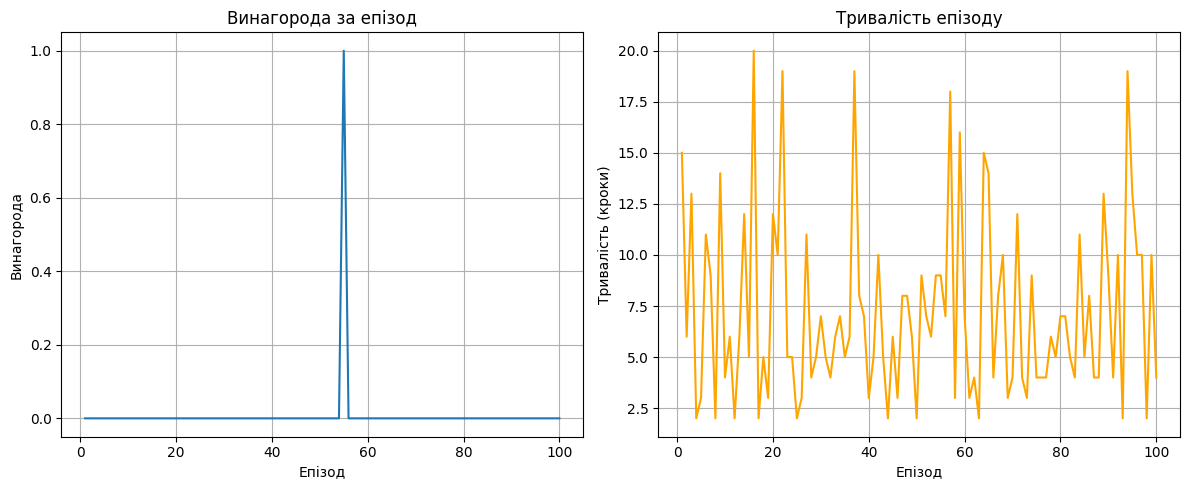

In [84]:
# Функція для запуску 100 епізодів і збирання даних
def run_episodes(env, num_episodes=100):
    rewards = []
    episode_lengths = []
    
    for _ in range(num_episodes):
        episode = get_episode(env)
        total_reward = sum([step[2] for step in episode])  # Сума винагород у епізоді
        episode_length = len(episode)  # Тривалість епізоду
        
        rewards.append(total_reward)
        episode_lengths.append(episode_length)
    
    return rewards, episode_lengths

# Запуск 100 епізодів
num_episodes = 100
rewards, episode_lengths = run_episodes(env, num_episodes)

# Побудова графіків
plt.figure(figsize=(12, 5))

# Графік 1: Винагорода за епізод
plt.subplot(1, 2, 1)
plt.plot(range(1, num_episodes + 1), rewards, label='Винагорода')
plt.xlabel('Епізод')
plt.ylabel('Винагорода')
plt.title('Винагорода за епізод')
plt.grid(True)

# Графік 2: Тривалість епізоду
plt.subplot(1, 2, 2)
plt.plot(range(1, num_episodes + 1), episode_lengths, label='Тривалість епізоду', color='orange')
plt.xlabel('Епізод')
plt.ylabel('Тривалість (кроки)')
plt.title('Тривалість епізоду')
plt.grid(True)

plt.tight_layout()
plt.show()

#### 7. Реалізувати метод Ітерації ціни (Value Iteration) для знаходження оптимальної стратегії за заданою початковою.

In [85]:
def value_iteration(env, gamma=0.75, theta=1e-6):
    """
    Реалізація методу Ітерації ціни (Value Iteration) для знаходження оптимальної стратегії.
    
    Параметри:
    - env: середовище Gymnasium (Frozen Lake).
    - gamma: коефіцієнт дисконтування (γ).
    - theta: поріг для перевірки збіжності.

    Повертає:
    - V: оптимальна функція ціни стану.
    - policy: оптимальна стратегія для кожного стану.
    """
    # Ініціалізуємо функцію ціни стану нулями
    V = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n, dtype=int)  # Стратегія: оптимальні дії для кожного стану

    # Отримуємо доступ до реального середовища
    env = env.unwrapped

    while True:
        delta = 0  # Відстежуємо максимальні зміни у функції ціни стану
        for s in range(env.observation_space.n):
            v = V[s]  # Зберігаємо поточне значення функції ціни стану
            
            # Оцінюємо значення функції ціни дії-стану для кожної дії
            action_values = np.zeros(env.action_space.n)
            for a in range(env.action_space.n):
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + gamma * V[next_state])
            
            V[s] = max(action_values)  # Оновлюємо V(s) як максимальне значення серед дій
            delta = max(delta, abs(v - V[s]))  # Оновлюємо максимальне відхилення

        # Перевірка на збіжність
        if delta < theta:
            break

    # Визначення оптимальної стратегії після збіжності
    for s in range(env.observation_space.n):
        action_values = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[s][a]:
                action_values[a] += prob * (reward + gamma * V[next_state])
        policy[s] = np.argmax(action_values)  # Вибір дії з максимальним значенням

    return V, policy

# Викликаємо функцію Ітерації ціни
optimal_values, optimal_policy = value_iteration(env)

# Виведення результатів
print("Оптимальна функція ціни стану V(s):")
print(optimal_values.reshape((4, 4)))

print("\nОптимальна стратегія π(s):")
print(optimal_policy.reshape((4, 4)))

Оптимальна функція ціни стану V(s):
[[0.23730469 0.31640625 0.421875   0.31640625]
 [0.31640625 0.         0.5625     0.        ]
 [0.421875   0.5625     0.75       0.        ]
 [0.         0.75       1.         0.        ]]

Оптимальна стратегія π(s):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


#### 8. Оцінити оптимальну стратегію $π_*$ та функцію ціни стану $v_*(s)$ для заданого середовища за допомогою методу Ітерації ціни, використовуючи в якості початкових параметрів стратегію $π_1$ та функції ціни $v_{π_1}(s)$. Порівняйте отриману функцію ціни $v_*(s)$ з функцією $v_{π_1}(s)$ з задання №2.

Функція ціни стану для випадкової стратегії π_1:
[[0.00092935 0.00110441 0.00385693 0.00115701]
 [0.0019954  0.         0.0144523  0.        ]
 [0.00771773 0.03144824 0.073222   0.        ]
 [0.         0.08678424 0.34461682 0.        ]]

Оптимальна функція ціни стану V*(s):
[[0.23730469 0.31640625 0.421875   0.31640625]
 [0.31640625 0.         0.5625     0.        ]
 [0.421875   0.5625     0.75       0.        ]
 [0.         0.75       1.         0.        ]]


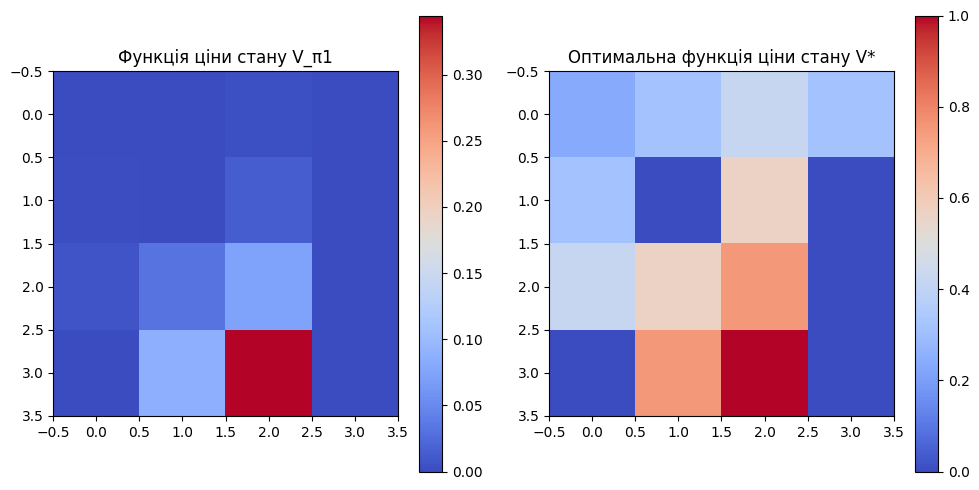

In [50]:
# Оцінка функції ціни стану для випадкової стратегії π_1 з пункту 2 (результат з policy_evaluation)
V_random_policy = policy_evaluation(env, policy)

# Використовуємо метод Ітерації ціни для знаходження оптимальної стратегії та функції ціни стану
V_optimal, optimal_policy = value_iteration(env)

# Порівнюємо функції ціни стану
print("Функція ціни стану для випадкової стратегії π_1:")
print(V_random_policy.reshape((4, 4)))

print("\nОптимальна функція ціни стану V*(s):")
print(V_optimal.reshape((4, 4)))

# Побудуємо графіки для порівняння функцій ціни стану
plt.figure(figsize=(10, 5))

# Графік для випадкової стратегії
plt.subplot(1, 2, 1)
plt.imshow(V_random_policy.reshape((4, 4)), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Функція ціни стану V_π1')

# Графік для оптимальної стратегії
plt.subplot(1, 2, 2)
plt.imshow(V_optimal.reshape((4, 4)), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Оптимальна функція ціни стану V*')

plt.tight_layout()
plt.show()

#### 9. Виконати 15 епізодів за допомогою функції $get$_$episode$ зі стратегією $π_*$. Виведіть на екран два графіки: винагорода та тривалість епізоду. Порівняйте результати з відповідними результатами завдання №6.

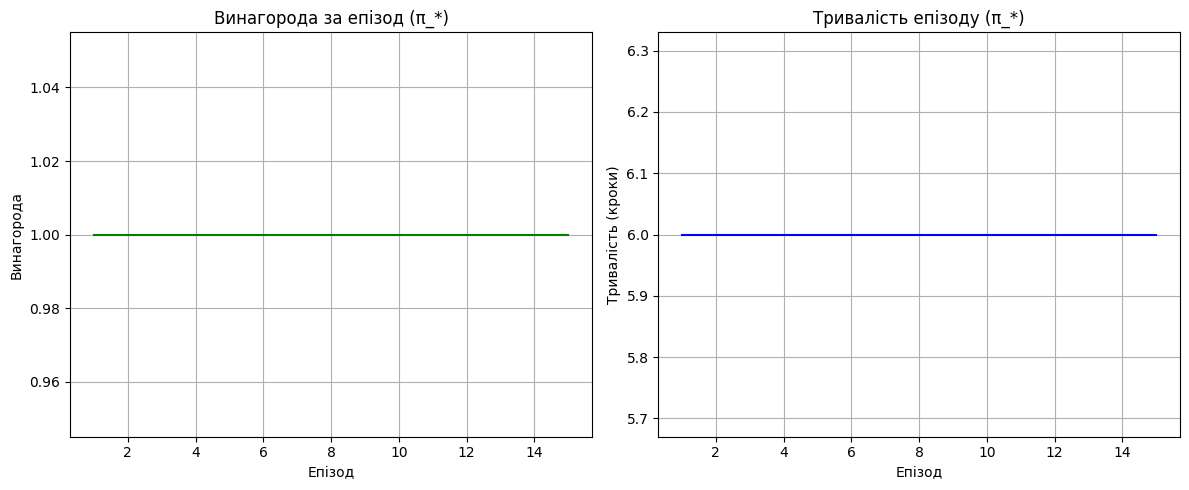

In [54]:
# Виправлена функція для отримання епізоду з використанням оптимальної стратегії
def get_episode_optimal(env, q_values):
    episode = []
    state, info = env.reset()  # reset повертає стан і інформацію
    done = False
    
    while not done:
        # Вибір дії на основі Q-значень: обираємо дію з максимальною Q-цінністю
        action = np.argmax(q_values[state])  # Оптимальна дія
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, next_state, terminated or truncated))
        state = next_state  # оновлюємо стан
        done = terminated or truncated
    
    return episode

# Функція для запуску 15 епізодів з оптимальною стратегією
def run_optimal_episodes(env, q_values, num_episodes=15):
    rewards = []
    episode_lengths = []
    
    for _ in range(num_episodes):
        episode = get_episode_optimal(env, q_values)
        total_reward = sum([step[2] for step in episode])  # Сума винагород у епізоді
        episode_length = len(episode)  # Тривалість епізоду
        
        rewards.append(total_reward)
        episode_lengths.append(episode_length)
    
    return rewards, episode_lengths

# Виконаємо 15 епізодів за допомогою оптимальної стратегії π_*
num_episodes = 15
optimal_rewards, optimal_episode_lengths = run_optimal_episodes(env, q_values)

# Побудова графіків для оптимальної стратегії
plt.figure(figsize=(12, 5))

# Графік 1: Винагорода за епізод для π_*
plt.subplot(1, 2, 1)
plt.plot(range(1, num_episodes + 1), optimal_rewards, label='Винагорода (π_*)', color='green')
plt.xlabel('Епізод')
plt.ylabel('Винагорода')
plt.title('Винагорода за епізод (π_*)')
plt.grid(True)

# Графік 2: Тривалість епізоду для π_*
plt.subplot(1, 2, 2)
plt.plot(range(1, num_episodes + 1), optimal_episode_lengths, label='Тривалість епізоду (π_*)', color='blue')
plt.xlabel('Епізод')
plt.ylabel('Тривалість (кроки)')
plt.title('Тривалість епізоду (π_*)')
plt.grid(True)

plt.tight_layout()
plt.show()

#### 10. Використовуючи знайдені занчення оптимальної функції ціни стану $v_*(s)$ та рівняння Белмана для функції ціни дії-стану, оцінити оптимальну функцію ціни дії-стану $q_*(s_j, a_j)$. Порівняйте результати з результатами завдання №3.

Оптимальна функція ціни дії-стану q_*(s, a):
[[6.97012896e-04 1.49654653e-03 8.28310221e-04 6.97012896e-04]
 [6.97012896e-04 0.00000000e+00 2.89269824e-03 8.28310221e-04]
 [8.28310221e-04 1.08392220e-02 8.67754265e-04 2.89269824e-03]
 [2.89269824e-03 0.00000000e+00 8.67754265e-04 8.67754265e-04]
 [1.49654653e-03 5.78829705e-03 0.00000000e+00 6.97012896e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.49165009e-02 0.00000000e+00 2.89269824e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.78829705e-03 0.00000000e+00 2.35861771e-02 1.49654653e-03]
 [5.78829705e-03 6.50881771e-02 5.49165009e-02 0.00000000e+00]
 [2.35861771e-02 2.58462616e-01 0.00000000e+00 1.08392220e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.50881771e-02 2.58462616e-01 2.35861771e-02]
 [6.50881771e-02 2.58462616e-01 1.00000000e+00 5.49165009e-02]
 [0.000000

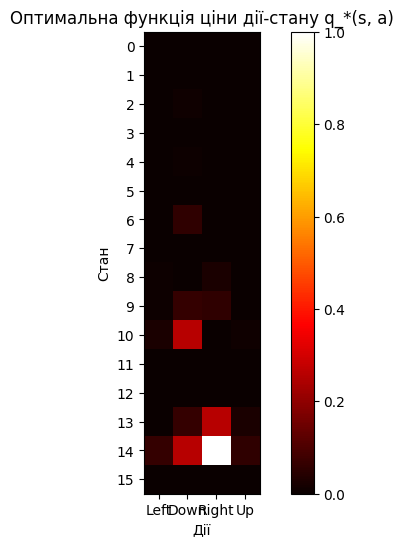

In [59]:
# Функція для оцінки оптимальної функції ціни дії-стану q_*(s, a)
def compute_optimal_q_values(env, v_optimal, gamma=0.75):
    q_star = np.zeros((env.observation_space.n, env.action_space.n))

    # Отримуємо доступ до реального середовища
    env = env.unwrapped
    
    for s in range(env.observation_space.n):  # для кожного стану
        for a in range(env.action_space.n):  # для кожної дії
            for prob, next_state, reward, done in env.P[s][a]:
                q_star[s, a] += prob * (reward + gamma * v_optimal[next_state])
    
    return q_star

# Використання знайдених значень оптимальної функції ціни стану v_*
optimal_q_values = compute_optimal_q_values(env, V)  # Використовуйте правильну змінну для функції ціни стану

# Виведення значень q_*(s, a) у вигляді матриці
print("Оптимальна функція ціни дії-стану q_*(s, a):")
print(optimal_q_values)

# Візуалізація q-значень у вигляді теплової карти
plt.figure(figsize=(8, 6))
plt.imshow(optimal_q_values, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Оптимальна функція ціни дії-стану q_*(s, a)")
plt.xlabel("Дії")
plt.ylabel("Стан")
plt.xticks(np.arange(env.action_space.n), ['Left', 'Down', 'Right', 'Up'])
plt.yticks(np.arange(env.observation_space.n))
plt.show()

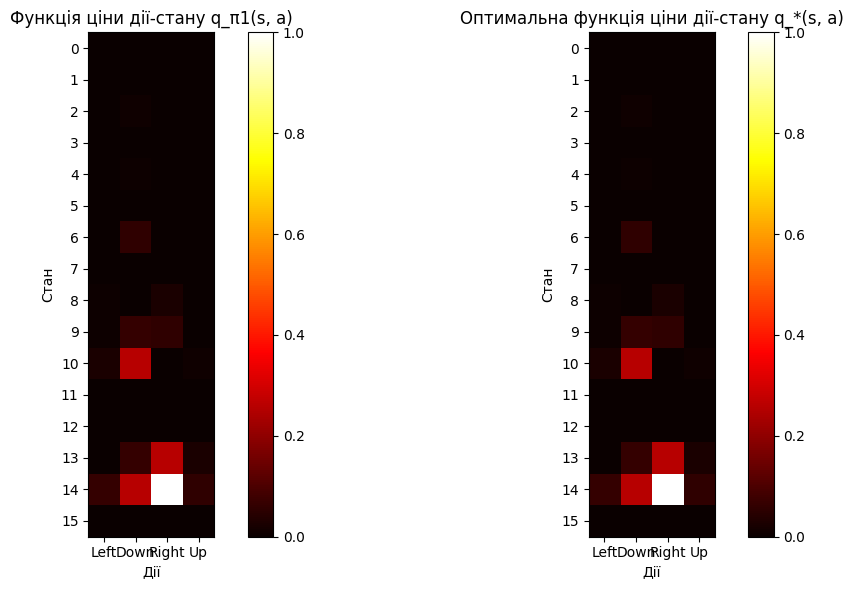

In [89]:
# Порівняння функцій q(s, a) для випадкової та оптимальної стратегій
q_values_random_policy = compute_q_values(env, V_random_policy)  # Значення для випадкової стратегії (з завдання №3)

plt.figure(figsize=(12, 6))

# Теплова карта для q_π1 (випадкова стратегія)
plt.subplot(1, 2, 1)
plt.imshow(q_values_random_policy, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Функція ціни дії-стану q_π1(s, a)")
plt.xlabel("Дії")
plt.ylabel("Стан")
plt.xticks(np.arange(env.action_space.n), ['Left', 'Down', 'Right', 'Up'])
plt.yticks(np.arange(env.observation_space.n))

# Теплова карта для q_*(оптимальна стратегія)
plt.subplot(1, 2, 2)
plt.imshow(optimal_q_values, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Оптимальна функція ціни дії-стану q_*(s, a)")
plt.xlabel("Дії")
plt.ylabel("Стан")
plt.xticks(np.arange(env.action_space.n), ['Left', 'Down', 'Right', 'Up'])
plt.yticks(np.arange(env.observation_space.n))

plt.tight_layout()
plt.show()

#### 11. Створити функцію $eps$_\$greedy$_$policy$, аргументами якої є масив значень функції ціни дії-стану $q(s, a)$ та параметр $ε$, та результатом є номер дії, обраний з множини номерів допустимих дій за допомогою методу $ε$-жадібної стратегії ($ε$-greedy policy).

In [121]:
# Реалізація ε-жадібної стратегії
def eps_greedy_policy(q_values, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values[state]))  # Випадковий вибір дії
    else:
        return np.argmax(q_values[state])  # Вибір дії з максимальним Q-значенням

# Приклад використання
epsilon = 0.1  # Параметр ε
q_values = np.array([[0, 1, 0, 0],  # Q-значення для стану 0
                     [0, 0, 1, 0],  # Q-значення для стану 1
                     [1, 0, 0, 0],  # Q-значення для стану 2
                     [0, 0, 0, 1]]) # Q-значення для стану 3
state = 1  # Поточний стан агента

# Використовуємо ε-жадібну політику для вибору дії у стані 1
action = eps_greedy_policy(q_values, state, epsilon)
print(f"Обрана дія у стані {state}: {action}")

Обрана дія у стані 1: 2


#### 12. Реалізувати метод 𝔼-SARSA (Expected SARSA) для знаходження оптимальної функції ціни дії-стану $q_*(s, a)$ за заданою початковою.

In [122]:
# Метод E-SARSA з постійним значенням ε
def expected_sarsa(env, num_episodes, alpha, gamma, epsilon):
    q_values = np.zeros((env.observation_space.n, env.action_space.n))

    for episode in range(num_episodes):
        state, _ = env.reset()
        action = eps_greedy_policy(q_values, state, epsilon)

        done = False
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if not done:
                next_action = eps_greedy_policy(q_values, next_state, epsilon)
                expected_q = np.sum(q_values[next_state] * (1 - epsilon)) + epsilon * np.max(q_values[next_state])

                q_values[state, action] += alpha * (reward + gamma * expected_q - q_values[state, action])
                state = next_state
                action = next_action
            else:
                q_values[state, action] += alpha * (reward - q_values[state, action])

    return q_values

# Параметри для навчання
num_episodes = 1000  # Кількість епізодів
alpha = 0.1  # Темп навчання
gamma = 0.99  # Дисконтований фактор
epsilon = 0.1  # Параметр ε для жадібної стратегії

# Виконання E-SARSA
optimal_q_values = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)

# Виведення отриманих значень q_*(s, a)
print("")
print("Оптимальна функція ціни дії-стану q_*(s, a):")
print(optimal_q_values)


Оптимальна функція ціни дії-стану q_*(s, a):
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#### 13. Оцінити оптимальну функцію ціни дії-стану $q_*(s, a)$ для заданого середовища за допомогою методу 𝔼-SARSA, використовуючи $ε$-жадібну стратегію та функцію ціни дії-стану $q_{π_1}(s, a)$. Використайте дві стратегії задання значення параметра:
> **a. задання постійного значення $ε$ ∈ {0,1 ; 0,5};**

> **b. зміна значення $ε$ за законом $ε(k) = \frac{1}{k}$, де $k ∈ \{1, 2, 3, ..., K\}$, $K$ є кількістю епізодів для навчання.**

#### Порівняйте отримані оцінки функцій $q_*(s, a)$ з функціями $q_{π_1}(s, )$ та $q_*(s, a)$ з завдань №3, №10. Оберіть кращу оцінку функції $q_*(s, a)$ і відповідне їй значення параметра $ε$.

In [123]:
# Метод E-SARSA з змінним ε
def expected_sarsa_with_variable_epsilon(env, num_episodes, alpha, gamma):
    q_values = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()  # Скидання середовища
        action = eps_greedy_policy(q_values, state, epsilon=1/episode)  # Використання ε(k) = 1/k

        done = False
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if not done:
                next_action = eps_greedy_policy(q_values, next_state, epsilon=1/episode)
                expected_q = np.sum(q_values[next_state] * (1 - 1/episode)) + (1 - np.sum(1 - 1/episode)) * np.max(q_values[next_state])

                q_values[state, action] += alpha * (reward + gamma * expected_q - q_values[state, action])
                state = next_state
                action = next_action
            else:
                q_values[state, action] += alpha * (reward - q_values[state, action])

    return q_values

# Зберегти значення q для порівняння
def compare_q_values(q_values_1, q_values_2, q_values_3):
    """
    Функція для порівняння трьох різних q-значень.
    """
    print("Порівняння q-значень:")
    print("q_{π_1}(s, a):")
    print(q_values_1)
    
    print("Оптимальна функція ціни дії-стану q_*(s, a) з ε=0.1:")
    print(q_values_2)

    print("Оптимальна функція ціни дії-стану q_*(s, a) з ε=0.5:")
    print(q_values_3)

# Ініціалізація середовища
env = gym.make('FrozenLake-v1', is_slippery=False)

# Параметри для навчання
num_episodes = 1000  # Кількість епізодів
alpha = 0.1  # Темп навчання
gamma = 0.75  # Дисконтований фактор

# Виконання E-SARSA з постійним ε
q_values_constant_0_1 = expected_sarsa(env, num_episodes, alpha, gamma, epsilon=0.1)
q_values_constant_0_5 = expected_sarsa(env, num_episodes, alpha, gamma, epsilon=0.5)

# Виконання E-SARSA з змінним ε
q_values_variable = expected_sarsa_with_variable_epsilon(env, num_episodes, alpha, gamma)

# Порівняння результатів
# Для прикладу, q_values_pi1 можна взяти як деякі раніше отримані значення
q_values_pi1 = np.random.rand(env.observation_space.n, env.action_space.n)  # Це просто приклад

compare_q_values(q_values_pi1, q_values_constant_0_1, q_values_constant_0_5)

# Вивід q_*(s, a) для змінного ε
print("Оптимальна функція ціни дії-стану q_*(s, a) з змінним ε:")
print(q_values_variable)

Порівняння q-значень:
q_{π_1}(s, a):
[[0.71196441 0.55942389 0.49690295 0.05424877]
 [0.91184014 0.53787276 0.16004172 0.04103511]
 [0.68945195 0.84500536 0.53661907 0.83771786]
 [0.06593451 0.51673623 0.52370367 0.63047801]
 [0.74678935 0.04687556 0.85210775 0.68733792]
 [0.13059981 0.15387376 0.899861   0.31269142]
 [0.01066541 0.54450201 0.0599612  0.38905565]
 [0.82430349 0.6371088  0.08705592 0.51640625]
 [0.89814499 0.78361095 0.1025267  0.6842699 ]
 [0.27179788 0.88595749 0.57333881 0.63305467]
 [0.69086838 0.80930021 0.12051992 0.68733496]
 [0.67712085 0.06041802 0.15737919 0.64421128]
 [0.9120024  0.9606633  0.36910505 0.9897417 ]
 [0.93938409 0.8130507  0.43698312 0.47494851]
 [0.72141804 0.31461002 0.87964762 0.8437917 ]
 [0.50282255 0.42934533 0.62632052 0.79904029]]
Оптимальна функція ціни дії-стану q_*(s, a) з ε=0.1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0.

#### 14. Створіть на основі функції $q_*(s, a)$ з завдання №13 $ε$-жадібну стратегію $π_2$.

In [125]:
# Створення нової ε-жадібної стратегії π_2
def create_policy_pi2(q_values, epsilon):
    """
    Створення стратегії π_2 на основі Q-значень.
    
    :param q_values: Матриця Q-значень
    :param epsilon: Параметр ε
    :return: Стратегія π_2
    """
    policy = np.zeros(q_values.shape[0], dtype=int)  # Ініціалізація політики

    for state in range(q_values.shape[0]):
        # Використовуємо ε-жадібну стратегію для вибору дії для кожного стану
        policy[state] = eps_greedy_policy(q_values, state, epsilon)

    return policy

# Задаємо параметр ε для нової стратегії π_2
epsilon_pi2 = 0.1  # Ви можете змінити це значення за потреби

# Створюємо стратегію π_2
policy_pi2 = create_policy_pi2(q_values_variable, epsilon_pi2)

# Виводимо результат
print("Нова ε-жадібна стратегія π_2:")
print(policy_pi2)

Нова ε-жадібна стратегія π_2:
[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2]


#### 15. Виконати 100 епізодів за допомогою функції $get$_$episode$ зі стратегією $π_2$, отриманою у завданні №14. Виведіть на екран два графіки: винагорода та тривалість епізоду. Порівняйте результати з відповідними результатами завдань №6, №9.